# Summary #

<div class= 'alert alert-block alert-success'>
<b>The Titanic:</b>

The titanic sunk. Many died.\
Can we <b>predict those who survived</b>?
***
<b>Strategy:</b>
* Main features are SEX (passenger gender) and PCLASS (passenger ticket class);
* Engineered features are the quartiles of ticket FARE;
* Extracted features are based on combinations of 
    * PCLASS (passenger ticket class), 
    * SEX (passenger gender), 
    * EMBARKED (port where passengers came aboar the Titanic), 
    * CHILD (whether the passenger is or not aged up to five years old), 
    * TITLE (passenger title extracted from name), 
    * FAMILY (SIBSP and PARCH, related to total number of the passengers' spouses, siblings, parents, and children aboard the Titanic), and 
    * FARE (ticket price);
* the data was modeled with a cross-validated Logistic Regression, with a final f1 score of 0.86 (died) and 0.69 (survived);
* the Kaggle score on the (unseen) dataset is 0.79.
***
<b>Classification report for predictions on trial data (split from the provided training data):</b>

                              precision    recall  f1-score   support

    Predicted not to survive       0.78      0.96      0.86       137
        Predicted to survive       0.91      0.56      0.69        86

                    accuracy                           0.81       223
                   macro avg       0.84      0.76      0.78       223
                weighted avg       0.83      0.81      0.79       223
***
The model seems to perform poorly when predicting who survived (f1 score of 0.69). However, the training and (unseen) test data seem to have different distributions of target classes, and/or features. Improving the prediction of who survived can be attained by overfitting the data (drastically lowering predictions on test set) or by imputing ordinal features (like setting the CABINID, the FARE/AGE quartiles, etc to numerical values). The current approach is sufficiently automated and "trick"-free.
</div>

# Import packages, load data #

In [482]:
### IMPORT
### GENERAL PACKAGES
import numpy as np, pandas as pd, statsmodels.api as sm
import os

### SETUP
pd.set_option('display.max_columns', None)

### PLOTTING
import seaborn as sns, matplotlib.pyplot as plt

### DATA MANIPULATION
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD

### MODELS
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB, ComplementNB, BernoulliNB

### EXPORTING MODELS
import pickle

### VALIDATION
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report

In [483]:
# LOOK FOR FILES
!ls /kaggle/input/titanic/

gender_submission.csv  test.csv  train.csv


In [484]:
# LOAD DATA
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")

# Exploratory Data Analysis (EDA)

# Inspect data for completeness #

In [485]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [486]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<div class="alert alert-block alert-info">
<b>Features:</b>
    
* PassengerId (integer) - sequential number, probably assigned at boarding;
* Survived={0,1} - whether the passenger survived the accident or not;
* Pclass={1,2,3} - ticket class of passenger;
* Name (string) - passenger name, with title;
* Sex={'male', 'female'} - passenger Gender;
* Age (float) - passenger age;
* SibSp (integer) - number of passenger siblings or spouses aboard the Titanic;
* Parch (integer) - number of passenger parents or children aboard the Titanic;
* Ticket (string) - a ticket identification tag;
* Fare (float) - ticket fare;
* Cabin (string) - cabin identification tag;
* Embarked={S,C,Q} - the port where the passenger embarked the Titanic.    
</div>    

In [487]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


<div class= 'alert alert-block alert-danger'>
<b>Missing train data:</b>

* 891 entries, with data types int64, float64, and string
* many entries missing from AGE and, especially, CABIN
</div>

In [488]:
# CHECKING FOR DUPLICATED VALUES
df_train.duplicated().sum()

0

In [489]:
# CHECK TEST DATA
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [490]:
df_test.duplicated().sum()

0

# Trying to figure out _why_ there is missing data

In [491]:
def count_records(featcounts:str, feat:str, norecord:bool):
    """
    Counts FEATCOUNTS occurrences of each category of SEX, PCLASS, EMBARKED, FAMILY=SIBSP+PARCH
    for cases where FEAT={AGE,CABIN} records are absent or not (NORECORD={TRUE, FALSE})
    """
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Sex'] == 'male')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Sex'] == 'female')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 1)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 2)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Pclass'] == 3)]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'S')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'C')]))
    featcounts.append(len(df_train[(df_train[feat].isna() == norecord) & (df_train['Embarked'] == 'Q')]))

In [492]:
# COUNTS OF NO AGE OR CABIN RECORD AT EACH PASSENGER CLASS, GENDER, PORT, FAMILY=SIBSP+PARCH
df_records = pd.DataFrame()
df_records['Feature'] = ['Gender(M)', 'Gender(F)', 'Class(1st)','Class(2nd)', 'Class(3rd)', 
                       'Port(Southampton)', 'Port(Cherbourg)', 'Port(Queenstown)']

counts_age = []; counts_noage = []; counts_cabin = []; counts_nocabin = []

count_records(counts_age, 'Age', False)
count_records(counts_noage, 'Age', True)
count_records(counts_cabin, 'Cabin', False)
count_records(counts_nocabin, 'Cabin', True)

df_records['Age_record'] = counts_age
df_records['No_age_record'] = counts_noage
df_records['Cabin_record'] = counts_cabin
df_records['No_cabin_record'] = counts_nocabin

print("""Number of passengers with/without AGE or CABIN records depending on GENDER, ticket CLASS,
port of EMBARKment:\n\n""", df_records)

Number of passengers with/without AGE or CABIN records depending on GENDER, ticket CLASS,
port of EMBARKment:

              Feature  Age_record  No_age_record  Cabin_record  No_cabin_record
0          Gender(M)         453            124           107              470
1          Gender(F)         261             53            97              217
2         Class(1st)         186             30           176               40
3         Class(2nd)         173             11            16              168
4         Class(3rd)         355            136            12              479
5  Port(Southampton)         554             90           129              515
6    Port(Cherbourg)         130             38            69               99
7   Port(Queenstown)          28             49             4               73


<div class="alert alert-block alert-info">
<b>Notes on data inspection:</b>

* TICKET data seems useless; some are strings with only numeric values, some are alphanumeric - useful information should correlate with FARE;
* PASSENGERID data is useless;    
* missing data could stem from port services, due to a much larger volume of inbound passengers:
    * about 70% of missing AGE/CABIN data related to 3rd class ticket passengers, with a similar percentage for male passengers
    * Southampton was the embarcation port for 72% of all passengers
</div>

<div class= 'alert alert-block alert-warning'>
<b>About train data completeness:</b>

* 891 entries, with data types int64, float64, and string
* 177 values missing from AGE field
* 687 values missing from CABIN field
* 2 values missing from EMBARK field
* no duplicate entries

<b>About test data completeness:</b>

* 418 entries, with data types int64, float64, and string
* test data also has missing values for AGE (327) and CABIN (86), and one missing entry for FARE
* no duplicate entries
</div>

## Univariate Distributions

In [493]:
# CREATE LIST OF FEATURES TO KEEP
select_features = []

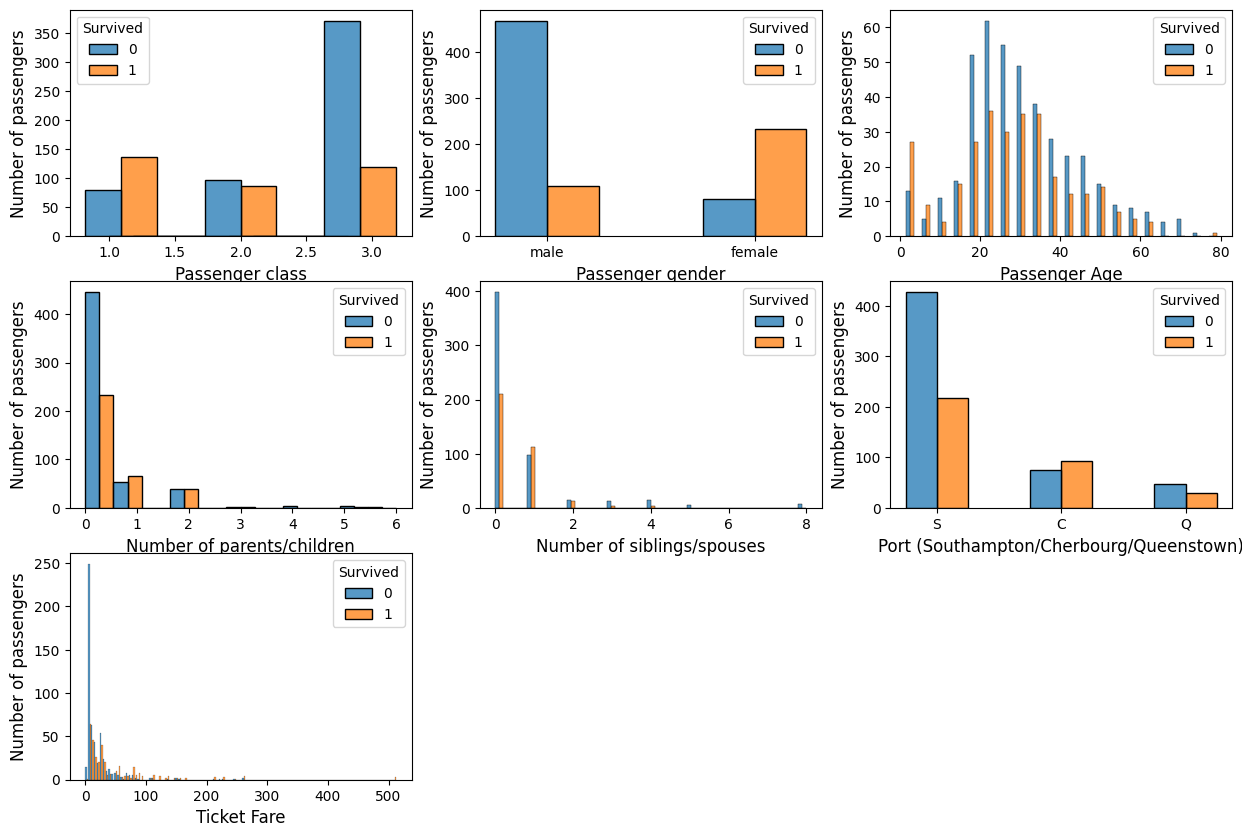

In [494]:
# ONE-DIMENSIONAL DISTRIBUTIONS
# SET FIGURE SIZE AND GRID SIZE
fig = plt.figure(figsize = (15,10))
gs = plt.GridSpec(3,3, height_ratios=(1,1,1))

# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
g6 = plt.subplot(gs[1, 2])
g7 = plt.subplot(gs[2, 0])


ax1 = sns.histplot(ax=g1, data = df_train, x='Pclass',hue = 'Survived', stat='count', multiple='dodge',shrink=3)
ax1.set_xlabel('Passenger class', fontsize=12)
ax1.set_ylabel('Number of passengers', fontsize=12)

ax2 = sns.histplot(ax=g2, data = df_train, x='Sex',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax2.set_xlabel('Passenger gender', fontsize=12)
ax2.set_ylabel('Number of passengers', fontsize=12)

ax3 = sns.histplot(ax=g3, data = df_train, x='Age',hue = 'Survived', stat='count', multiple='dodge',shrink=0.5)
ax3.set_xlabel('Passenger Age', fontsize=12)
ax3.set_ylabel('Number of passengers', fontsize=12)

ax4 = sns.histplot(ax=g4, data = df_train, x='Parch',hue = 'Survived', stat='count', multiple='dodge')
ax4.set_xlabel('Number of parents/children', fontsize=12)
ax4.set_ylabel('Number of passengers', fontsize=12)

ax5 = sns.histplot(ax=g5, data = df_train, x='SibSp',hue = 'Survived', stat='count', multiple='dodge')
ax5.set_xlabel('Number of siblings/spouses', fontsize=12)
ax5.set_ylabel('Number of passengers', fontsize=12)

ax6 = sns.histplot(ax=g6, data = df_train, x='Embarked',hue = 'Survived', stat='count', multiple='dodge', shrink=0.5)
ax6.set_xlabel('Port (Southampton/Cherbourg/Queenstown)', fontsize=12)
ax6.set_ylabel('Number of passengers', fontsize=12)

ax7 = sns.histplot(ax=g7, data = df_train, x='Fare',hue = 'Survived', stat='count', multiple='dodge', shrink=1)
ax7.set_xlabel('Ticket Fare', fontsize=12)
ax7.set_ylabel('Number of passengers', fontsize=12)

fig.show()

In [495]:
select_features.append('Sex') ; select_features.append('Pclass')

<div class="alert alert-block alert-success">
<b>Notes on features:</b>

* SEX is the best predictor: males are most likely not to survive, the opposite for females;
* Passengers in PCLASS=1 are more likely to survive, those in PCLASS=3 are more likely not to survive;
* Passengers without family members aboard (SIBSP, PARCH) are more likely to die;
* Child passengers (AGE under 10) are more likely to live;
* Port of EMBARKment and ticket FARE probably correlate with SEX and PCLASS;
* FARE skews heavily to the right.    
</div>

## Creating the FAMILY features ##

In [496]:
# FamilyYN = PARCH + SIBSP >0 OR NOT
# DEFINE FUNCTION TO ASSIGN FAMILY VALUES BASED ON PARCH AND SIBSP
def fam(parch:int, sibsip:int):
    if (parch==0) & (sibsip==0):
        return 'no'
    else:
        return 'yes'
# APPLY FUNCTION
df_train['FamilyYN'] = df_train.apply(lambda x: fam(x.Parch, x['SibSp']), axis=1)
df_test['FamilyYN'] = df_test.apply(lambda x: fam(x.Parch, x['SibSp']), axis=1)
# FAMILY = PARCH + SIBSP
df_train['Family'] = df_train['SibSp'] + df_train['Parch']
df_test['Family'] = df_test['SibSp'] + df_test['Parch']
# FAMILY SIZE, ACCORDING TO VARIATION IN SURVIVED FEATURE
def famsize(family):
    if family == 0:
        return 'alone'
    elif family < 4:
        return 'small'
    else:
        return 'large'
# APPLY FUNCTION; pd.Categorical SETS AN ORDINALITY TO THE CATEGORIES THAT WILL BE USED WHEN, E.G., PLOTTING
df_train['Famsize'] = pd.Categorical(df_train['Family'].apply(famsize), categories=['alone', 'small', 'large'])
df_test['Famsize'] = pd.Categorical(df_test['Family'].apply(famsize), categories=['alone', 'small', 'large'])

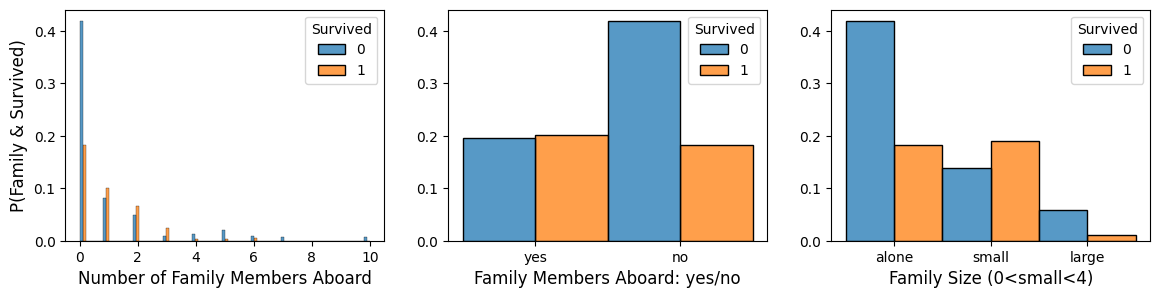

In [497]:
# PLOT FAMILY FEATURES
fig_fam = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
# PLOT FAMILY, FAMILY_YN, FAMSIZE
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['Family', 'FamilyYN', 'Famsize']
xlbl_list = ['Number of Family Members Aboard', 'Family Members Aboard: yes/no', 'Family Size (0<small<4)']
ylbl_list = ['P(Family & Survived)', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
fig_fam.show()

In [498]:
# APPEND FEATURE
select_features.append('FamilyYN')

<div class="alert alert-block alert-success">
<b>FAMSIZE feature:</b>

* Passengers who travel without family members or with large families (more than four family members in total) are much less likely to survive;
* Passengers travelling with up to three other family members (small families) are more likely to survive.
</div>

## Extracting Titles from the NAME feature ##

In [499]:
# WRITE A FUNCTION TO SPLIT THE NAME STRING AND EXTRACT THE TITLE
def detach(inp):
    return list(inp.split(','))[1].split()[0]

# APPLY FUNCTION TO NAME FEATURE
df_train['Title'] = df_train['Name'].apply(lambda x: detach(x))
df_test['Title'] = df_test['Name'].apply(lambda x: detach(x))
# THERE IS A TITLE SPELLED "THE", WHICH BELONGS TO A COUNTESS: INDEX 759
df_train.loc[759,'Title'] = 'Countess'
# GROUP TITLES IN DICTIONARY ACCORDING TO DISTRIBUTION VS SURVIVED
# TEST DATA HAS A TITLE DONA, ABSENT FROM TRAIN DATA, INSERTED BELOW
titlegroup = {}
titlegroup.update(dict.fromkeys(['Mr.', 'Miss.', 'Mrs.', 'Ms.'],'Common'))
titlegroup.update(dict.fromkeys(['Master.', 'Dr.', 'Rev.', 'Major.', 'Col.', 'Capt.'],'Professional'))
titlegroup.update(dict.fromkeys(['Don.', 'Dona.', 'Sir.', 'Lady.', 'Mlle.', 'Mme.','Jonkheer.', 'Countess'],'Wealth'))
titledictcommon = {}
titledictcommon.update(dict.fromkeys(['Mr.', 'Miss.', 'Mrs.', 'Ms.'],'yes'))
titledictcommon.update(dict.fromkeys(['Master.', 'Dr.', 'Rev.', 'Major.', 'Col.', 'Capt.', 'Don.', 'Dona.', 'Sir.', 'Lady.', 'Mlle.', 'Mme.','Jonkheer.', 'Countess'],'no'))
# GROUP TITLES
df_train['Titlegroup'] = df_train['Title'].map(titlegroup)
df_test['Titlegroup'] = df_test['Title'].map(titlegroup)
# SIMPLIFY TITLES
df_train['Titlecommon'] = df_train['Title'].map(titledictcommon)
df_test['Titlecommon'] = df_test['Title'].map(titledictcommon)

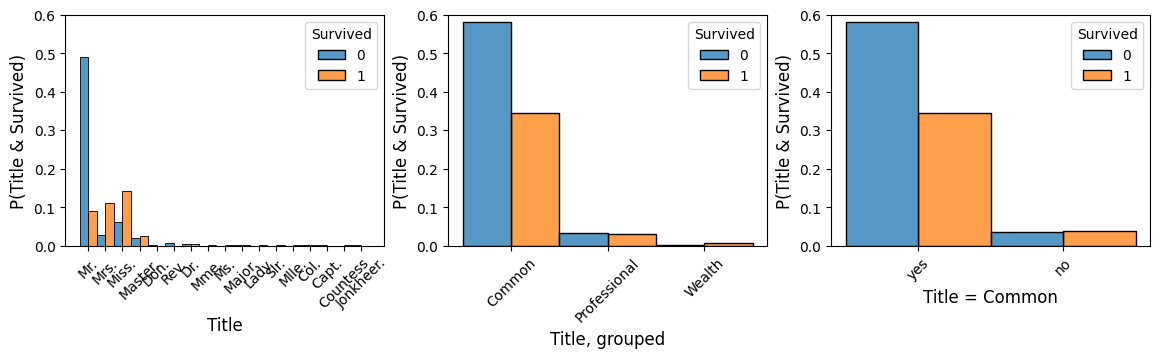

In [500]:
# PLOT TITLE FEATURES
fig_ttl = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
# PLOT TITLE, TITLEGROUP, TITLESIMPLE
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['Title', 'Titlegroup', 'Titlecommon']
xlbl_list = ['Title', 'Title, grouped', 'Title = Common']
ylbl_list = ['P(Title & Survived)', 'P(Title & Survived)', 'P(Title & Survived)']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
    axis.tick_params(axis='x', rotation = 45)
    axis.set_ylim(0,0.6)
    fig_ttl.show()

<div class="alert alert-block alert-success">
<b>TITLE features:</b>

* Survivability due to female passengers' titles mostly due to passenger SEX;
* Passengers with TITLECOMMON=yes are less likely to survive;
* Passengers with TITLECOMMON=no are as likely to survive as not.
</div>

## Filling the FARE field in test data ##

In [501]:
# PASSENGERS WITHOUT FARE DATA IN TEST DATASET
df_test[df_test['Fare'].isna() == True]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyYN,Family,Famsize,Title,Titlegroup,Titlecommon
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,no,0,alone,Mr.,Common,yes


In [502]:
# CALCULATE MEDIAN OF FARE FOR RELEVANT PASSENGER FEATURES IN THE TRAIN DATASET AND ASSIGN IT
# 3rd PCLASS, MALE, NO FAMILY, SOUTHAMPTON
med_fare = df_train[(df_train['Pclass'] == 3) & (df_train['Sex'] == 'male') & (df_train['FamilyYN'] == 'no') & (df_train['Embarked'] == 'S')]['Fare'].median()
df_test['Fare'] = df_test['Fare'].fillna(med_fare)

## Binning FARE into Quartiles ##

In [503]:
# BINNING FARE VALUES INTO QUARTILES
def quarts(fare):
    q1 = df_train['Fare'].quantile(0.25)
    q2 = df_train['Fare'].quantile(0.50)
    q3 = df_train['Fare'].quantile(0.75)
    if fare < q1:
        return 'Q1'
    elif fare < q2:
        return 'Q2'
    elif fare < q3:
        return 'Q3'
    elif fare >= q3:
        return 'Q4'

df_train['FareQ'] = pd.Categorical(df_train.apply(lambda x: quarts(x['Fare']), axis=1), categories = ['Q1', 'Q2', 'Q3', 'Q4'])
df_test['FareQ'] = pd.Categorical(df_test.apply(lambda x: quarts(x['Fare']), axis=1), categories = ['Q1', 'Q2', 'Q3', 'Q4'])

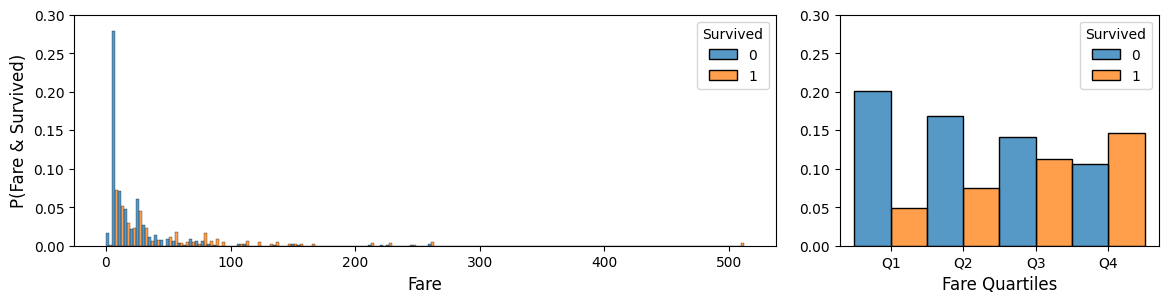

In [504]:
# PLOT FARE FEATURES
fig_fare = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0:2])
g2 = plt.subplot(gs[0, 2])
# PLOT FARE, FARE_Q, FARE_Q4
ax_list = ['ax1', 'ax2']
gpts_list = [g1, g2]
feat_list = ['Fare', 'FareQ']
xlbl_list = ['Fare', 'Fare Quartiles']
ylbl_list = ['P(Fare & Survived)', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
    axis.set_ylim(0,0.3)
fig_fare.show()

In [505]:
# APPEND FEATURE
select_features.append('FareQ')

<div class="alert alert-block alert-success">
<b>FARE_Q4 feature:</b>

* Ratio of survived:dead increases with FAREQ
</div>

## Filling the EMBARKED field ##

In [506]:
# THE TWO MISSING EMBARKED VALUES IN THE TRAIN DATA ARE FOR FIRST CLASS FEMALES WITHOUT FAMILY ABOARD
# SHARING A CABIN, SO THE PORT COULD BE THE SAME
df_train[df_train['Embarked'].isna() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyYN,Family,Famsize,Title,Titlegroup,Titlecommon,FareQ
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,no,0,alone,Miss.,Common,yes,Q4
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,no,0,alone,Mrs.,Common,yes,Q4


In [507]:
# LOOKING AT RECORDS FROM FEMALES, WITHOUT FAMILY, FIRST CLASS
print(df_train[(df_train['Pclass'] == 1) & (df_train['FamilyYN'] == 'no') & (df_train['Sex'] == 'female')].groupby('Embarked')['PassengerId'].count())
# OVER 50% PROBABILITY THAT BOTH CAME FROM CHERBOURG, SO WE'LL ASSIGN THAT AS EMBARKED PORT
df_train['Embarked'].fillna('C', inplace=True)

Embarked
C    18
S    14
Name: PassengerId, dtype: int64


In [508]:
# GROUPING EMBARKED INTO SOUTHAMPTON=Yes/No, ACCORDING TO DISTRIBUTION OF EMBARKED AND SURVIVED
def portsouth(port):
    if port == 'S':
        return 'yes'
    else:
        return 'no'
df_train['PortSH'] = pd.Categorical(df_train['Embarked'].apply(portsouth), categories = ['no', 'yes'])
df_test['PortSH'] = pd.Categorical(df_test['Embarked'].apply(portsouth), categories = ['no', 'yes'])

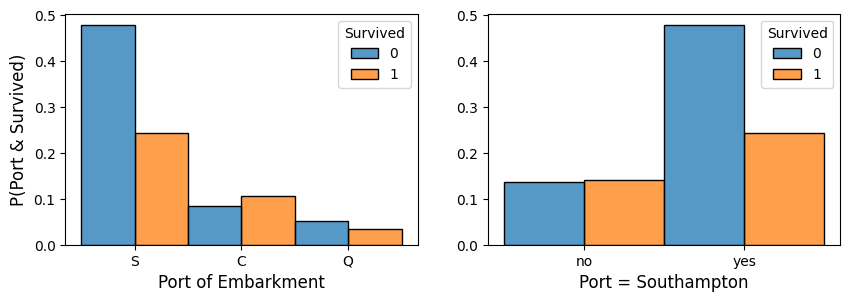

In [509]:
# PLOT EMBARKED FEATURES
fig_port = plt.figure(figsize = (10,3))
gs = plt.GridSpec(1,2)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
# PLOT EMBARKED, PORT_SH
ax_list = ['ax1', 'ax2']
gpts_list = [g1, g2]
feat_list = ['Embarked', 'PortSH']
xlbl_list = ['Port of Embarkment', 'Port = Southampton']
ylbl_list = ['P(Port & Survived)', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
fig_port.show()

<div class="alert alert-block alert-success">
<b>PORT_SH feature:</b>

* Passengers embarking in Southampton are less likely to survive;
* Passengers embarking in other ports are as likely to survive as not;
</div>

## Creating the CabinId feature ##

In [510]:
# COUNTS OF CABIN IDENTIFIERS INCLUDING ONLY DIGITS (NOT LETTERS)
df_train['Cabin'].str.isnumeric().value_counts()

Cabin
False    204
Name: count, dtype: int64

In [511]:
# GET CABIN IDENTIFIER LETTER(S)
# THERE ARE TOO MANY CABINID CATEGORIES (EX: B, BB, BBB, BBBB), SO WE'LL KEEP ONLY THE FIRST LETTER
# THIS MEANS, FROM 1ST TO 3RD CLASS: T, A, B, C, D, E, F, G
def firstlet(cabin:str):
    if pd.isna(cabin)==False:
        return str(cabin)[0]
# APPLY FUNCITON
df_train['CabinId'] = pd.Categorical(df_train['Cabin'].apply(firstlet), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])
df_test['CabinId'] = pd.Categorical(df_test['Cabin'].apply(firstlet), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'])

In [512]:
df_train.groupby(['Pclass', 'CabinId']).PassengerId.count()

Pclass  CabinId
1       A          15
        B          47
        C          59
        D          29
        E          25
        F           0
        G           0
        T           1
2       A           0
        B           0
        C           0
        D           4
        E           4
        F           8
        G           0
        T           0
3       A           0
        B           0
        C           0
        D           0
        E           3
        F           5
        G           4
        T           0
Name: PassengerId, dtype: int64

<div class="alert alert-block alert-danger">
ENTRY 339 WAS PERMANENTLY DELETED!
</div>

In [513]:
# CBN_COMP=T IS A SINGLE ENTRY FOR THE CABIN, AND MAY RESULT IN PROBLEMS LATER ON
# WE WILL ELIMINATE THIS ENTRY PERMANENTLY (INDEX 339)
df_train = df_train.drop(index=339).reset_index(drop=True)

<div class="alert alert-block alert-danger">
ENTRY 339 WAS PERMANENTLY DELETED!
</div>

## Filling the CABINID field ##

In [514]:
# PEARSON CORRELATION BETWEEN CABINID AND OTHER FEATURES
corr = pd.get_dummies(df_train.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin'], axis=1)).corr()
# GET ROW AND COLUMN NUMBERS FOR -0.4 < PEARSON CORRELATION < 0.4 (USING ONLY LOWER HALF OF CORRELATION MATRIX)
row,col =  np.nonzero(abs(np.triu(corr.iloc[-7:,:-7]))>0.3)
# GET FEATURES NAME FROM COLUMN INDEXES
colname = []
for i,j in enumerate(corr.iloc[-8:,:-8].columns):
    if i in col:
        colname.append(j)
print(colname)

['Pclass', 'Fare', 'FareQ_Q4']


In [515]:
# CREATE FUNCTION TO READ FEATURES WITH HIGHEST CORRELATION WITH CABINID (FARE AND FAREQ, THE OTHERS ARE REDUNDANT),
# FOR EACH CABINID=NaN ENTRY, EXTRACT ALL CABINID VALUES FOR SIMILAR FEATURES, 
# AND ASSIGN A RANDOMLY SAMPLED CABINRS VALUE
def sampler(fare:float, fare_q:str, pclass:int, cabinid:str):
    if pd.isnull(cabinid) == True:
        df = df_train[df_train['CabinId'].isna() == False]
        cbn_list = list(df[(df['Fare'] == fare) & (df['FareQ'] == fare_q) & (df['Pclass'] == pclass)]['CabinId'])
        if len(cbn_list) != 0:
            return np.random.choice(cbn_list)
        else:
            # MOST COMMON CABINID VALUE IS C
            return 'C'
    else:
        return cabinid
# RUN FUNCTION OVER CABINID
df_train['CabinRS'] = pd.Categorical(df_train.apply(lambda x: sampler(x['Fare'], x['FareQ'], x['Pclass'], x['CabinId']), axis=1), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O'])
# FOR TEST DATA, USING THE SAME FUNCTION AS FOR THE TRAIN DATA
df_test['CabinRS'] = pd.Categorical(df_test.apply(lambda x: sampler(x['Fare'], x['FareQ'], x['Pclass'], x['CabinId']), axis=1), categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O'])

<div class="alert alert-block alert-info">
<b>Note on CABINID:</b>

* There are no features having a Pearson correlation coefficients larger than 0.4 with CABINID;
    * This was likely the cause of the failure in modeling CABINID with regressions, trees, and Naive Bayes (another notebook)
* The random sampling strategy will be tested, but likely abandoned;
* CABINID values will be imputed as the mode value of all entries.
</div>

In [516]:
# FINDING MOST COMMON CABINID VALUES
print(df_train['CabinId'].value_counts())
# FILL NaN VALUES IN CABINID WITH CABINID=C
df_train['CabinC'] = df_train['CabinId'].fillna('C')
df_test['CabinC'] = df_test['CabinId'].fillna('C')

CabinId
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     0
Name: count, dtype: int64


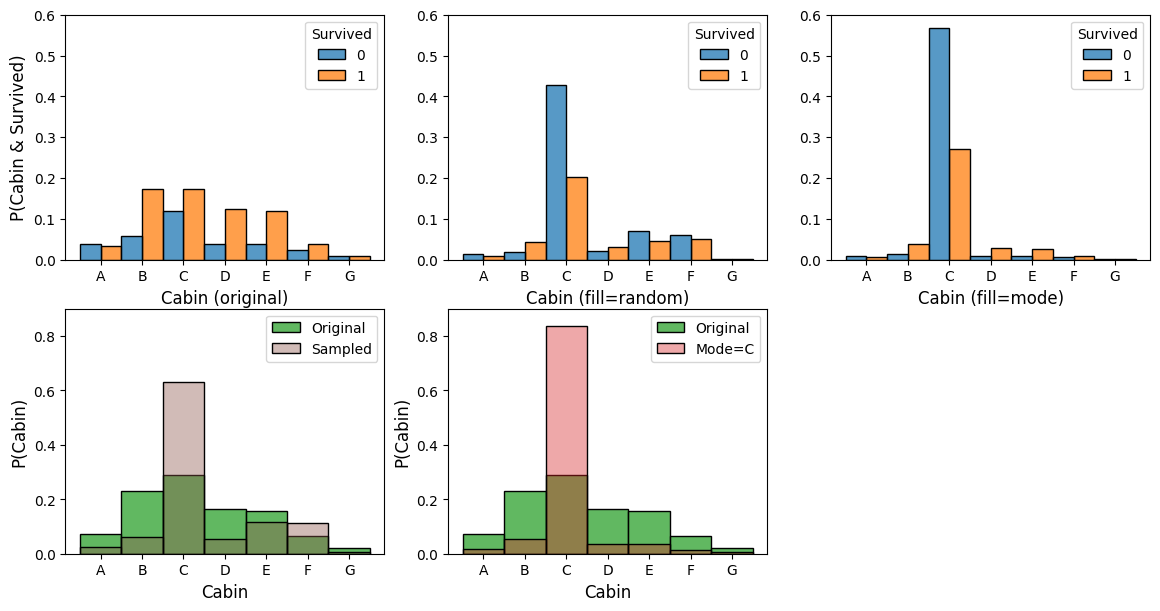

In [517]:
# PLOT CABINID FEATURES
fig_cbn = plt.figure(figsize = (14,7))
gs = plt.GridSpec(2,3, height_ratios=(1,1))
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
# PLOT CABINID, CABINRS, CABINC
ax_list = ['ax1', 'ax2', 'ax3']
gpts_list = [g1, g2, g3]
feat_list = ['CabinId', 'CabinRS', 'CabinC']
xlbl_list = ['Cabin (original)', 'Cabin (fill=random)', 'Cabin (fill=mode)']
ylbl_list = ['P(Cabin & Survived)', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
    axis.set_ylim(0,0.6)
# PLOT COMPARISON OF ORIGINAL DISTRIBUTION AND DISTRIBUTIONS WITH ASSIGNED VALUES
ax4 = sns.histplot(ax=g4, data=df_train, x='CabinId', stat='probability', color='tab:green', label='Original')
ax4 = sns.histplot(ax=g4, data=df_train, x='CabinRS', stat='probability', color='tab:brown', label='Sampled', alpha=0.4)
ax4.legend()
ax4.set_xlabel('Cabin', fontsize=12)
ax4.set_ylabel('P(Cabin)', fontsize=12)
ax4.set_ylim(0,0.9)
ax5 = sns.histplot(ax=g5, data=df_train, x='CabinId', stat='probability', color='tab:green', label='Original')
ax5 = sns.histplot(ax=g5, data=df_train, x='CabinC', stat='probability', color='tab:red', label='Mode=C', alpha=0.4)
ax5.legend()
ax5.set_xlabel('Cabin', fontsize=12)
ax5.set_ylabel('P(Cabin)', fontsize=12)
ax5.set_ylim(0,0.9)
fig_cbn.show()

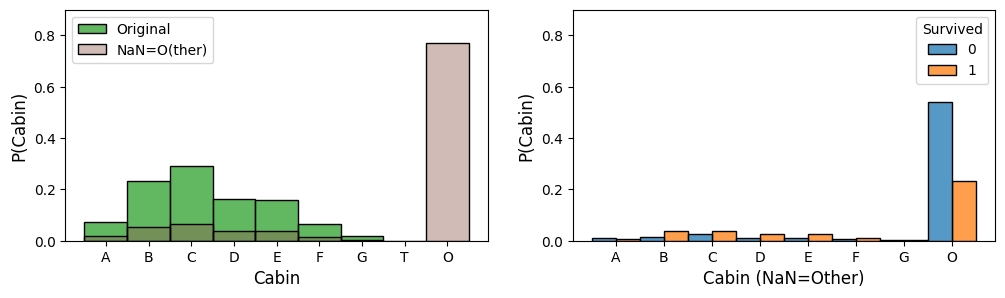

In [518]:
# ASSIGNING NaN VALUES IN CABIN ID TO THE CATEGORY O(THER)
df_train['CabinIdO'] = pd.Categorical(df_train['CabinId'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O']).fillna('O')
df_test['CabinIdO'] = pd.Categorical(df_test['CabinId'], categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'O']).fillna('O')
# PLOT CABINID FEATURES
fig_cbno = plt.figure(figsize = (12,3))
# PLOT CABINID, CABINIDO
g1 = plt.subplot(1,2,1)
sns.histplot(ax=g1, data=df_train, x='CabinId', stat='probability', color='tab:green', label='Original')
sns.histplot(ax=g1, data=df_train, x='CabinIdO', stat='probability', color='tab:brown', label='NaN=O(ther)', alpha=0.4)
g1.legend()
g1.set_xlabel('Cabin', fontsize=12)
g1.set_ylabel('P(Cabin)', fontsize=12)
g1.set_ylim(0,0.9)
g2 = plt.subplot(1,2,2)
sns.histplot(ax=g2, data=df_train, x='CabinIdO', stat='probability', hue='Survived', multiple='dodge')
g2.set_xlabel('Cabin (NaN=Other)', fontsize=12)
g2.set_ylabel('P(Cabin)', fontsize=12)
g2.set_ylim(0,0.9)
fig_cbno.show()

In [519]:
# CREATING BINARY FEATURE FOR CABINS WITH LARGER ODDS OF SURVIVING
def cabsurv(cbn):
    if cbn in ['B', 'C', 'D', 'E', 'F']:
        return 'yes'
    else:
        return 'no'
df_train['Cabinsurvival'] = df_train['CabinIdO'].apply(cabsurv)
df_test['Cabinsurvival'] = df_test['CabinIdO'].apply(cabsurv)

<div class="alert alert-block alert-success">
<b>Note on CABINID AND CABINIDO:</b>

* Both random sampling and mode replacement assignment strategies decrease the original distributions' spread, heavily emphasising the occurrence of label C (as expected) while also reversing the probability ratio of surviving/not_surviving for cabin C;
    * this means the most populated CABINID feature now reports the opposite trend in survival probability;
* Missing CABINID entries will be instead assigned the value O(ther); this at least preserves the original distributions and has a large not_survive/survive ratio.
</div>

## Filling the AGE field ##

In [520]:
# PEARSON CORRELATION BETWEEN CABINID AND OTHER FEATURES
corr = pd.get_dummies(df_train.drop(['PassengerId', 'Name', 'Ticket', 'Survived', 'Cabin', 'CabinId', 'CabinRS', 'CabinC'], axis=1)).corr()
# SORTED CORRELATION VALUES
print('Ten highest correlated features with age:\n', pd.concat([corr.iloc[1,:].sort_values().head(5), corr.iloc[1,:].sort_values().tail(5)]))
# KEEP TITLE, PCLASS, SIBSP, FAMILY
# FOR EACH AGE=NaN ENTRY, EXTRACT ALL AGE VALUES FOR SIMILAR FEATURES, AND ASSIGN A RANDOMLY SAMPLED AGE VALUE
def sampler(pclass:int, family:str, sibsp:str, title:str, age:int):
    if pd.isnull(age) == True:
        df = df_train[df_train['Age'].isna() == False]
        age_list = list(df[(df['Pclass'] == pclass) & (df['Family'] == family) & (df['SibSp'] == sibsp) & (df['Title'] == title)]['Age'])
        if len(age_list) != 0:
            return np.random.choice(age_list)
        else:
            # MOST COMMON AGE VALUE IS 22.0
            return 22.0
    else:
        return age
# RUN FUNCTION OVER AGE
df_train['AgeRS'] = df_train.apply(lambda x: sampler(x['Pclass'], x['Family'], x['SibSp'], x['Title'], x['Age']), axis=1)
# FOR TEST DATA, USING THE SAME FUNCTION AS FOR THE TRAIN DATA
df_test['AgeRS'] = df_test.apply(lambda x: sampler(x['Pclass'], x['Family'], x['SibSp'], x['Title'], x['Age']), axis=1)

# FILL NaN VALUES IN AGE WITH MEDIAN AGE VALUE
agemed = df_train['Age'].quantile(0.5)
df_train['Agemed'] = df_train['Age'].fillna(agemed)
df_test['Agemed'] = df_test['Age'].fillna(agemed)
# BINNING AGE_RS INTO PERCENTILES
q1 = df_train['AgeRS'].quantile(0.25)
q2 = df_train['AgeRS'].quantile(0.50)
q3 = df_train['AgeRS'].quantile(0.75)

def ageq(age):
    if age<q1:
        return 'Q1'
    elif age<q2:
        return 'Q2'
    elif age<q3:
        return 'Q3'
    else:
        return 'Q4'

# ASSIGN AGE QUARTILES
df_train['AgeQ'] = pd.Categorical(df_train['AgeRS'].apply(ageq), categories = ['Q1', 'Q2', 'Q3', 'Q4'])
df_test['AgeQ'] = pd.Categorical(df_test['AgeRS'].apply(ageq), categories = ['Q1', 'Q2', 'Q3', 'Q4'])

Ten highest correlated features with age:
 Title_Master.       -0.398812
Pclass              -0.367893
SibSp               -0.307737
Family              -0.301293
Title_Miss.         -0.276307
Titlecommon_yes      0.197484
Titlegroup_Common    0.197484
Title_Mr.            0.205298
Cabinsurvival_yes    0.227811
Age                  1.000000
Name: Age, dtype: float64


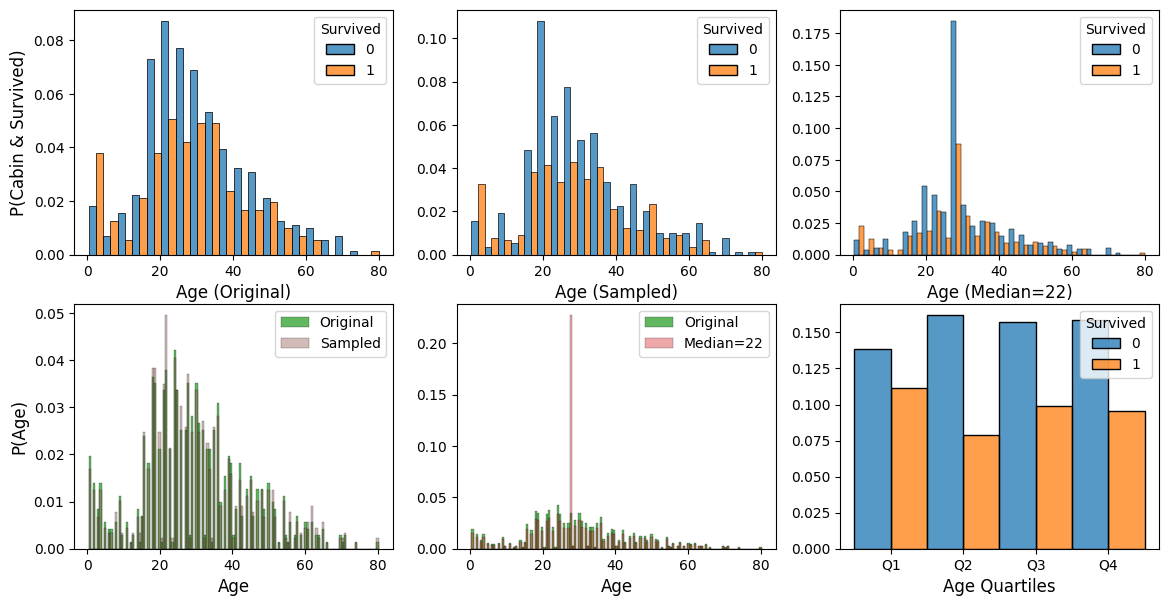

In [521]:
# PLOT AGE FEATURES
fig_age = plt.figure(figsize = (14,7))
gs = plt.GridSpec(2,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0])
g2 = plt.subplot(gs[0, 1])
g3 = plt.subplot(gs[0, 2])
g4 = plt.subplot(gs[1, 0])
g5 = plt.subplot(gs[1, 1])
g6 = plt.subplot(gs[1, 2])
# PLOT AGE, AGE_RS, AGEMED, AGE_Q
ax_list = ['ax1', 'ax2', 'ax3', 'ax6']
gpts_list = [g1, g2, g3, g6]
feat_list = ['Age', 'AgeRS', 'Agemed', 'AgeQ']
xlbl_list = ['Age (Original)', 'Age (Sampled)', 'Age (Median=22)', 'Age Quartiles']
ylbl_list = ['P(Cabin & Survived)', '', '', '']
for axis, gp, feat, xlabel, ylabel in zip(ax_list, gpts_list, feat_list, xlbl_list, ylbl_list):
    axis = sns.histplot(ax=gp, data = df_train, x=feat,hue = 'Survived', multiple='dodge', stat='probability')
    axis.set_xlabel(xlabel, fontsize=12)
    axis.set_ylabel(ylabel, fontsize=12)
# PLOT COMPARISON OF ORIGINAL DISTRIBUTION AND DISTRIBUTIONS WITH ASSIGNED VALUES
ax4 = sns.histplot(ax=g4, data=df_train, x='Age', stat='probability', color='tab:green', label='Original', binwidth=0.6)
ax4 = sns.histplot(ax=g4, data=df_train, x='AgeRS', stat='probability', color='tab:brown', label='Sampled', binwidth=0.6, alpha=0.4)
ax4.legend()
ax4.set_xlabel('Age', fontsize=12)
ax4.set_ylabel('P(Age)', fontsize=12)
ax5 = sns.histplot(ax=g5, data=df_train, x='Age', stat='probability', color='tab:green', label='Original', binwidth=0.6)
ax5 = sns.histplot(ax=g5, data=df_train, x='Agemed', stat='probability', color='tab:red', label='Median=22', binwidth=0.6, alpha=0.4)
ax5.legend()
ax5.set_xlabel('Age', fontsize=12)
ax5.set_ylabel('', fontsize=12)
fig_age.show()

In [522]:
# CREATE THE CHILD FEATURE ACCORDING TO AGE DISTRIBUTION FOR SURVIVED=YES
def child(age):
    if age<=5:
        return 'yes'
    else:
        return 'no'
df_train['Child'] = df_train['AgeRS'].apply(child)
df_test['Child'] = df_test['AgeRS'].apply(child)

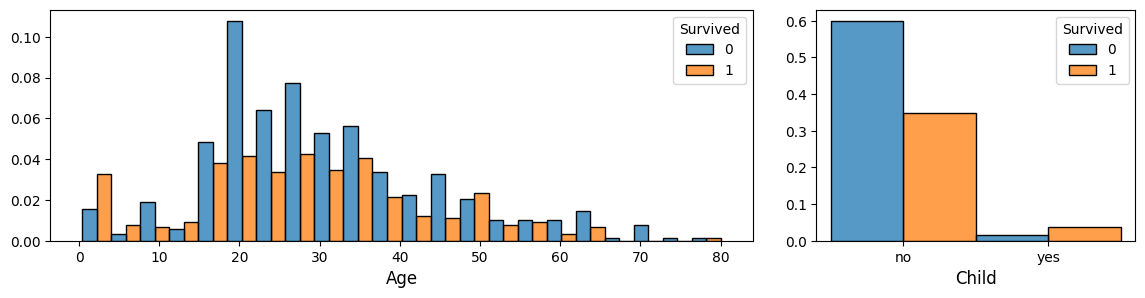

In [523]:
# PLOT AGE FEATURES
fig_age = plt.figure(figsize = (14,3))
gs = plt.GridSpec(1,3)
# SET GRID POSITIONS FOR PLOTS
g1 = plt.subplot(gs[0, 0:2])
g2 = plt.subplot(gs[0, 2])
# PLOT AGERS
ax1 = sns.histplot(ax=g1, data=df_train, x='AgeRS', stat='probability', hue='Survived', multiple='dodge')
ax1.set_xlabel('Age', fontsize=12)
ax1.set_ylabel('', fontsize=12)
ax2 = sns.histplot(ax=g2, data=df_train, x='Child', stat='probability', hue='Survived', multiple='dodge')
ax2.set_xlabel('Child', fontsize=12)
ax2.set_ylabel('', fontsize=12)
fig_age.show()

In [524]:
# APPEND FEATURE
select_features.append('Child')

<div class="alert alert-block alert-success">
<b>AGERS and CHILD features:</b>

* AGERS seems to mimick the original AGE distribution quite well;
* Children under 5 have a higher probability to survive.
</div>

<div class="alert alert-block alert-info">
<b>About lack of AGE and CABIN records:</b>

* there are sufficient AGE data that missing AGE records can be estimated;
    * regression model;
    * random sampling from distribution;
    * NaiveBayes;
    * ultimately, modeling didn't work well - the predictions were poor, so we went with random sampling instead;
* for CABIN data, there are many more missing data points;
    * all CABIN data start with one or more alphabet characters, from which CABINID was built;
    * CABINID varies the most with PCLASS;
    * CABINID could be estimated;
        * also, modeling didn't work well here;
        * sampling also didn't work - we assigned all missing features to an "other" category.
</div>

## Feature Extraction

<div class="alert alert-block alert-info">
<b>Feature Extraction:</b>

* Features will be extracted from features with smaller predictive power;
* combinations of two features will be performed (e.g., for the EMBARKED={S,Q,C} and CABINSURVIVAL={yes, no} features, combinations would be S_yes, S_no, Q_yes, etc);
* for each combination the ratio of survived/not_survived will be calculated;    
* this ratio will be used as the new metric for the feature EMBARKED_CABINSURVIVAL, meaning that each combination of these features in the data will be assigned the corresponding ratio in the new feature.
</div>

In [525]:
print(df_train.columns)
print(select_features)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'FamilyYN', 'Family',
       'Famsize', 'Title', 'Titlegroup', 'Titlecommon', 'FareQ', 'PortSH',
       'CabinId', 'CabinRS', 'CabinC', 'CabinIdO', 'Cabinsurvival', 'AgeRS',
       'Agemed', 'AgeQ', 'Child'],
      dtype='object')
['Sex', 'Pclass', 'FamilyYN', 'FareQ', 'Child']


In [526]:
# SETTING UP SOME AUXILIARY FEATURES MADE OF COMBINATIONS OF TWO FEATURES
# FOR EACH COMBINATION, THE RATIO BETWEEN SURVIVED TO DEAD PASSENGERS IS CALCULATED, AND THAT RATIO IS USED AS THE NEW FEATURE
# FUNCTION TO CALCULATE LIVE/DIE RATIO ON LIVE/DIE DATAFRAME
def ratio_ld(live,die):
    if die != 0:
        return (live/die)
    else:
        return live
# FUNCTION TO MAP FEATURE COMBINATIONS IN ORIGINAL DATAFRAME TO RATIO IN LIVE/DIE DATAFRAME
def map_to_ratio(fone, ftwo):
    try:
        return df_LD.loc[(df_LD[featone]==fone) & (df_LD[feattwo]==ftwo), 'Ratio_LD'].iloc[0]
    except:
        return 0
# CREATING COMPOSITE FEATURES TO ADD TO select_features
bivat_feats=[]
# SELECT FEATURES TO COMBINE
feats_for_extraction = ['Pclass', 'Sex', 'Embarked', 'FamilyYN', 'Family', 'Famsize', 'Titlegroup', 'Titlecommon', 
                        'FareQ', 'PortSH', 'CabinIdO', 'Cabinsurvival', 'AgeQ', 'Child']
for countone,featone in enumerate(feats_for_extraction):
    for counttwo,feattwo in enumerate(feats_for_extraction):
        if countone >= counttwo:
            continue
        else:
            # NUMBER OF SURVIVED=1 OR SURVIVED=0 PASSENGERS BY SEX AND PCLASS
            df_live=pd.DataFrame((df_train.loc[df_train['Survived']==1, [featone, feattwo, 'Survived']].groupby([featone, feattwo]).count())).reset_index()
            df_die=pd.DataFrame((df_train.loc[df_train['Survived']==0, [featone, feattwo, 'Survived']].groupby([featone, feattwo]).count())).reset_index()
            # CALCULATE RATIO OF SURVIVED TO DEAD
            df_LD = df_live.merge(df_die, on=[featone, feattwo], how='outer')
             #_x AND _y ARE AUTOMATIC SUFFIXES COMING FROM THE JOIN OPERATION
            # GETTING RID OF NaN VALUES THAT WILL MESS-UP THE RATIO CALCULATION
            df_LD['Survived_x'] = df_LD['Survived_x'].fillna(0)
            df_LD['Survived_y'] = df_LD['Survived_y'].fillna(0)
            # APPLYING FUNCTION TO CALCULATE RATIOS;
            df_LD['Ratio_LD'] = df_LD.apply(lambda x: ratio_ld(x['Survived_x'], x['Survived_y']), axis=1)
            # CONVERT FEATURE COMBINATIONS TO SURVIVED/DEAD RATIO
            new_feat = featone + '_' + feattwo
            df_train[new_feat] = df_train.apply(lambda x: map_to_ratio(x[featone], x[feattwo]), axis=1)
            df_test[new_feat] = df_test.apply(lambda x: map_to_ratio(x[featone], x[feattwo]), axis=1)
            bivat_feats.append(new_feat)
            del df_LD, df_live, df_die

# ADDING NEW FEATURES TO FEATURE LIST
select_features += bivat_feats

/tmp/ipykernel_32/2419358065.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[new_feat] = df_test.apply(lambda x: map_to_ratio(x[featone], x[feattwo]), axis=1)
/tmp/ipykernel_32/2419358065.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[new_feat] = df_test.apply(lambda x: map_to_ratio(x[featone], x[feattwo]), axis=1)
/tmp/ipykernel_32/2419358065.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

### Example: the new Famsize_FareQ feature

<Axes: xlabel='Famsize_FareQ', ylabel='Probability'>

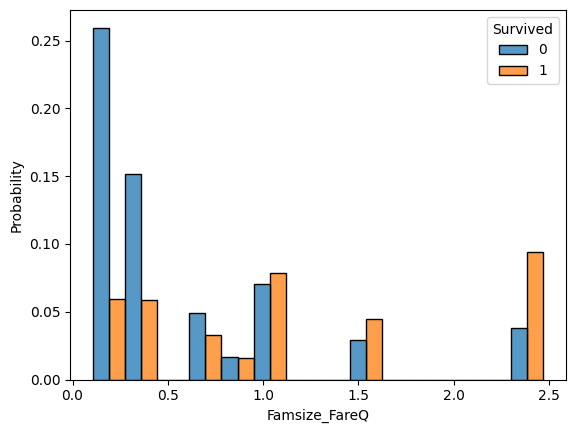

In [527]:
sns.histplot(data=df_train, x='Famsize_FareQ', hue='Survived', stat='probability', multiple='dodge')

# Modeling #

## Set-up variables, convert and scale data ##

<div class="alert alert-block alert-info">
<b>Preparing the data for modeling:</b>

* Features found relevant in the EDA and the extracted features will be on-hot encoded;
* One feature from feature pairs with a positive/negative pearson correlation coefficient beyond 0.65 will be discarded;
* From the remaining (uncorrelated) features, the 10 best features will be selected according to a chi^2 test against the target variable.
</div>

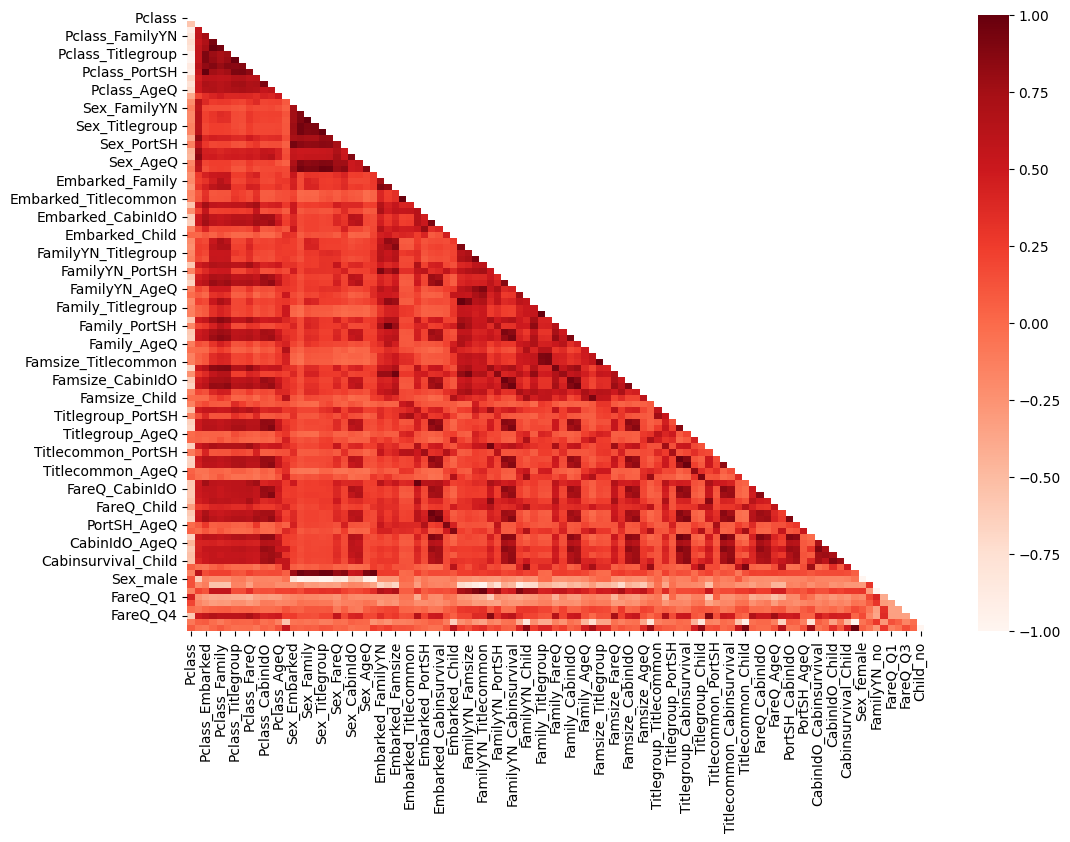

In [528]:
# CREATE DATAFRAMES WITH SELECTED FEATURES
df_train_select=df_train[select_features].copy()
df_test_select=df_test[select_features].copy()
# CONVERT CATEGORICAL DATA FOR LOGISTIC REGRESSION CLASSIFIER WITH ONE-HOT ENCODING
# DEFINE PREDICTOR AND OUTCOME VARIABLES
Xdum = pd.get_dummies(df_train_select, drop_first=False)
Xdum_test = pd.get_dummies(df_test_select, drop_first=False)
y = df_train['Survived']

# PLOT PEARSON CORRELATION BETWEEN FEATURES
corr = Xdum.corr()
uppertri = np.triu(corr)
fig = plt.figure(figsize=(12,8))
ax1=sns.heatmap(corr, annot=False, cmap='Reds', mask=uppertri)
fig.show()
# GET ROW AND COLUMN NUMBERS FOR LARGE PEARSON CORRELATION (BEYOND +/-0.65)
row,col =  np.nonzero((abs(np.tril(corr))>0.65))
# REMOVE REPEATED ENTRIES, E.G. 1,1 AND 2,2
lrow = [int(i) if i!=j else '' for i,j in zip(row,col)]
# REMOVE COLUMNS FROM Xncd
colname = []
for i,j in enumerate(corr.columns):
    if i in lrow:
        colname.append(j)
Xdum = Xdum.drop(colname, axis=1)
Xdum_test = Xdum_test.drop(colname, axis=1)  
# SELECT TOP 10 FEATURES BASED ON CHI^2 TEST
feat_index = SelectKBest(chi2, k=10).fit(Xdum,y).get_support(indices=True)
Xncd = Xdum.iloc[:,feat_index]
Xncd_test = Xdum_test.iloc[:,feat_index]

In [529]:
# SPLIT DATA INTO TRAINING AND TRIAL
X_train, X_trial, y_train, y_trial = train_test_split(Xncd, y, test_size=0.25, stratify=y, random_state=0)

## Fit model: Logistic Regression ##

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV parameters:  {'model_lg__C': 0.2}
                          precision    recall  f1-score   support

Predicted not to survive       0.78      0.96      0.86       137
    Predicted to survive       0.91      0.56      0.69        86

                accuracy                           0.81       223
               macro avg       0.84      0.76      0.78       223
            weighted avg       0.83      0.81      0.79       223

CPU times: user 304 ms, sys: 113 ms, total: 418 ms
Wall time: 2.6 s


<Figure size 200x200 with 0 Axes>

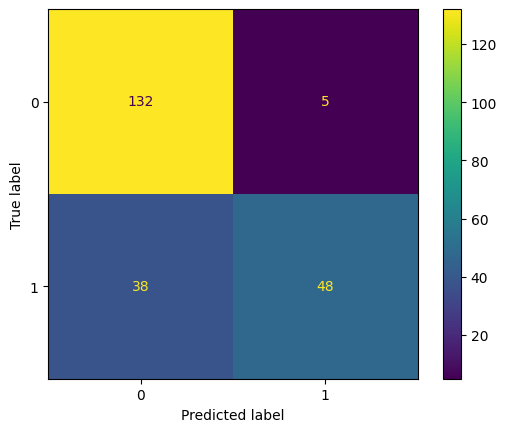

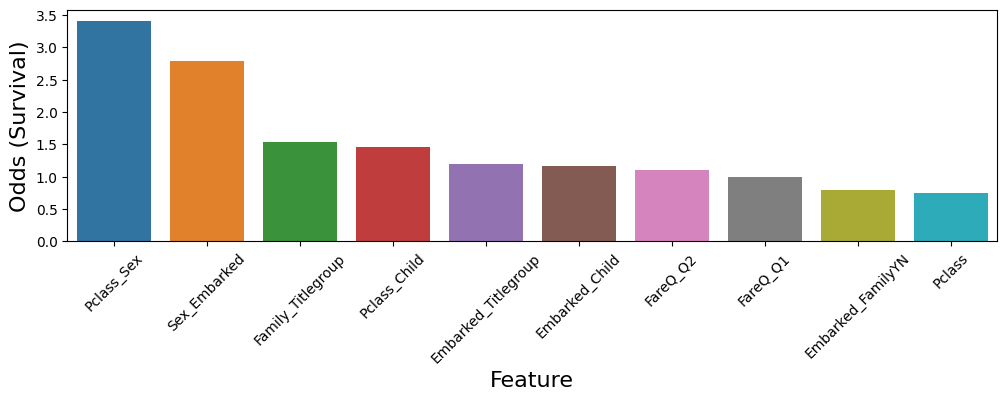

In [530]:
%%time
# SETUP MODEL, CROSS-VALIDATION
# PIPELINE FOR CV - THIS IS SCALING THE DATASET FOR EVERY CV FOLD, 
# EVEN THE ONES USING THE SAME DATA FOR TRAINING/TESTING, WHICH IS VEEERY INNEFICIENT...
pl_lg = Pipeline([('scale', StandardScaler()),
                ('model_lg', LogisticRegression(max_iter=1000, tol=0.0001, random_state=0))])
# CV PARAMETERS
par_grid_lg = {'model_lg__C' : [0.1, 0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 2.5]}
#CROSS-VALIDATION
# FIT MODEL
model_grid_lg = GridSearchCV(pl_lg, param_grid=par_grid_lg, cv=5, refit='f1', n_jobs = -1, verbose = 1)
model_grid_lg.fit(X_train, y_train)

# BEST PREDICTOR
best_lg = model_grid_lg.best_estimator_
print('Best CV parameters: ', model_grid_lg.best_params_)
# MAKE PREDICTIONS ON TRIAL AND TEST DATA
preds = best_lg.predict(X_trial)
preds_test = best_lg.predict(Xncd_test)    

# CLASSIFICATION REPORT
labels = ['Predicted not to survive', 'Predicted to survive']
clfrep = classification_report(y_trial, preds, target_names=labels)
print(clfrep)

# PLOT CONFUSION MATRIX
fig_cm = plt.figure(figsize=(2,2))
cm = confusion_matrix(y_trial, preds, labels = best_lg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=best_lg.classes_)
disp.plot(values_format='')
fig_cm.show()
# ODDS FROM LOGISTIC REGRESSION
fig_odd = plt.figure(figsize = (12,3))
odds = pd.DataFrame()
odds['Feature'] = X_trial.columns
odds['Odds'] = (np.exp(best_lg.named_steps['model_lg'].coef_.flatten()))
odds = odds.sort_values(by = 'Odds', ascending=False, key=abs)
ax=sns.barplot(data=odds, x='Feature', y='Odds')
ax.set_xlabel('Feature', fontsize=16)
ax.set_ylabel('Odds (Survival)', fontsize=16)
plt.xticks(rotation = 45)        
fig_odd.show()
# CREATE OUTPUT FILE FOR SUBMISSION
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': preds_test})
output.to_csv('submission.csv', index=False)